In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 2      

In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.shape)
print(adata.raw.shape)

(5589, 3058)
(5589, 18752)


In [5]:
# Subset for ctrl_13 sample.

adata = adata[adata.obs["sample"] == "ctrl_13",:]
print(adata.shape)

(1126, 3058)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


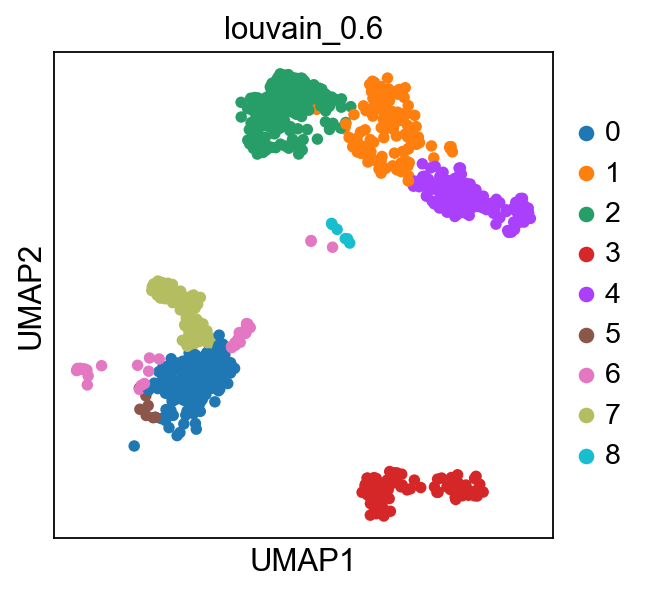

In [6]:
sc.pl.umap(adata, color=["louvain_0.6"], palette= sc.pl.palettes.default_20)

In [7]:
# load reference data
adata_ref = sc.datasets.pbmc3k_processed() 

try downloading from url
https://raw.githubusercontent.com/chanzuckerberg/cellxgene/main/example-dataset/pbmc3k.h5ad
... this may take a while but only happens once


  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [8]:
adata_ref.obs['sample']='pbmc3k'

print(adata_ref.shape)
adata_ref.obs

(2638, 1838)


,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,pbmc3k
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,pbmc3k
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,pbmc3k
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,pbmc3k
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,pbmc3k
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,pbmc3k
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,pbmc3k
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,pbmc3k


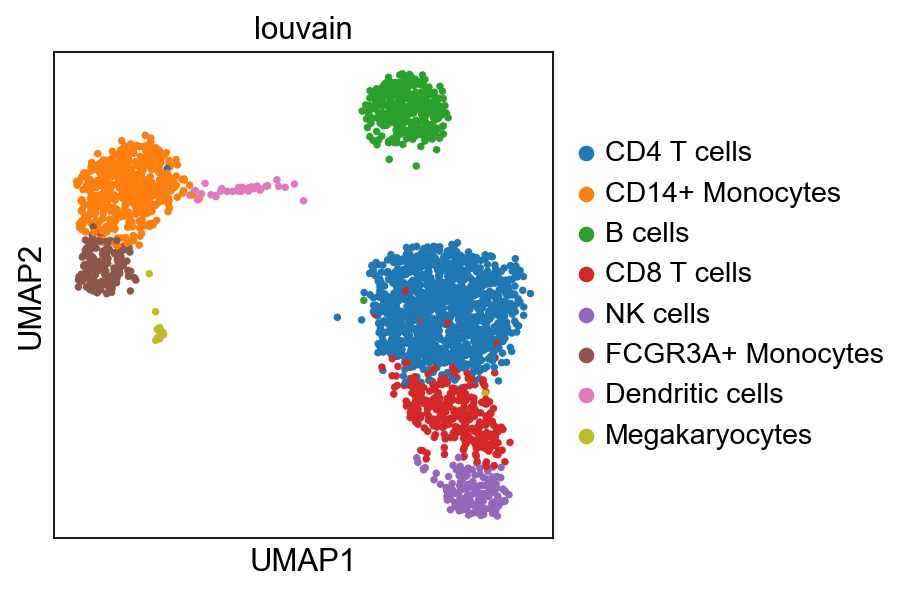

In [11]:
sc.pl.umap(adata_ref, color='louvain')

In [12]:
print(adata_ref.shape[1])
print(adata.shape[1])
var_names = adata_ref.var_names.intersection(adata.var_names)
print(len(var_names))

1838
3058
475


In [13]:
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:16)
computing UMAP
    finished (0:00:07)


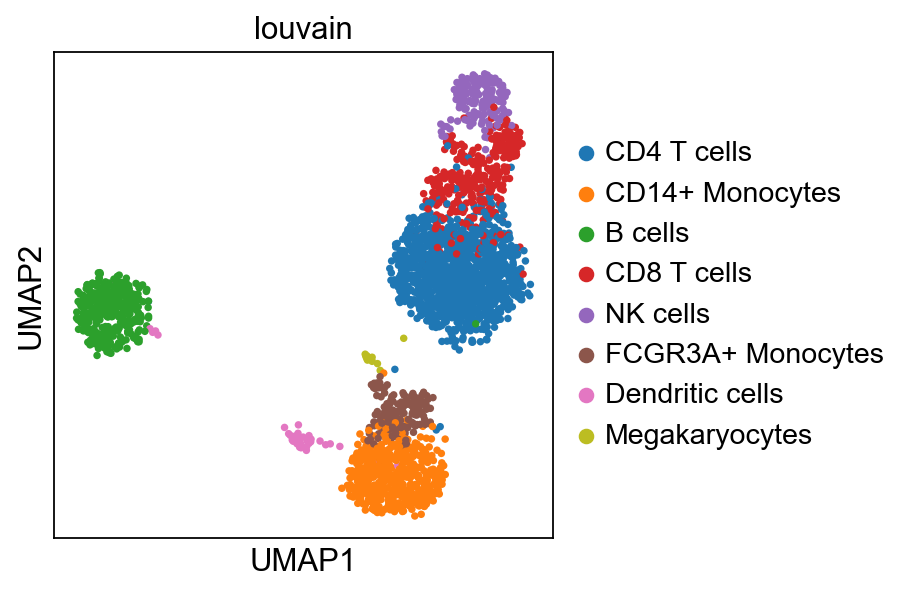

In [14]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color='louvain')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:03)


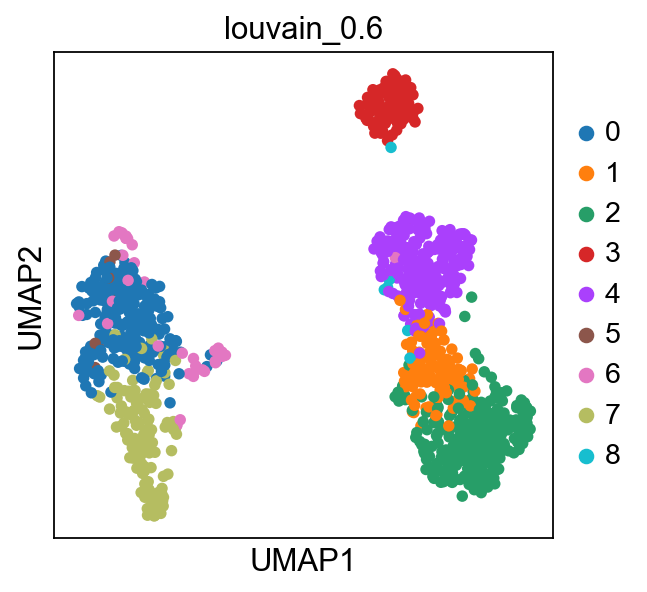

In [15]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='louvain_0.6')

### Integrate with scanorama

In [16]:
import scanorama


#subset the individual dataset to the same variable genes as in MNN-correct.
alldata = dict()
alldata['ctrl']=adata
alldata['ref']=adata_ref

#convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 475 genes among all datasets
[[0.         0.96980462]
 [0.         0.        ]]
Processing datasets (0, 1)


In [17]:
# add in sample info
adata_ref.obs['sample']='pbmc3k'

In [18]:
# create a merged scanpy object and add in the scanorama 
adata_merged = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample', batch_categories=['ctrl','pbmc3k'])

embedding = np.concatenate([ad.obsm['X_scanorama'] for ad in adatas], axis=0)

adata_merged.obsm['Scanorama'] = embedding

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [19]:
#run  umap.
sc.pp.neighbors(adata_merged, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata_merged)

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:09)


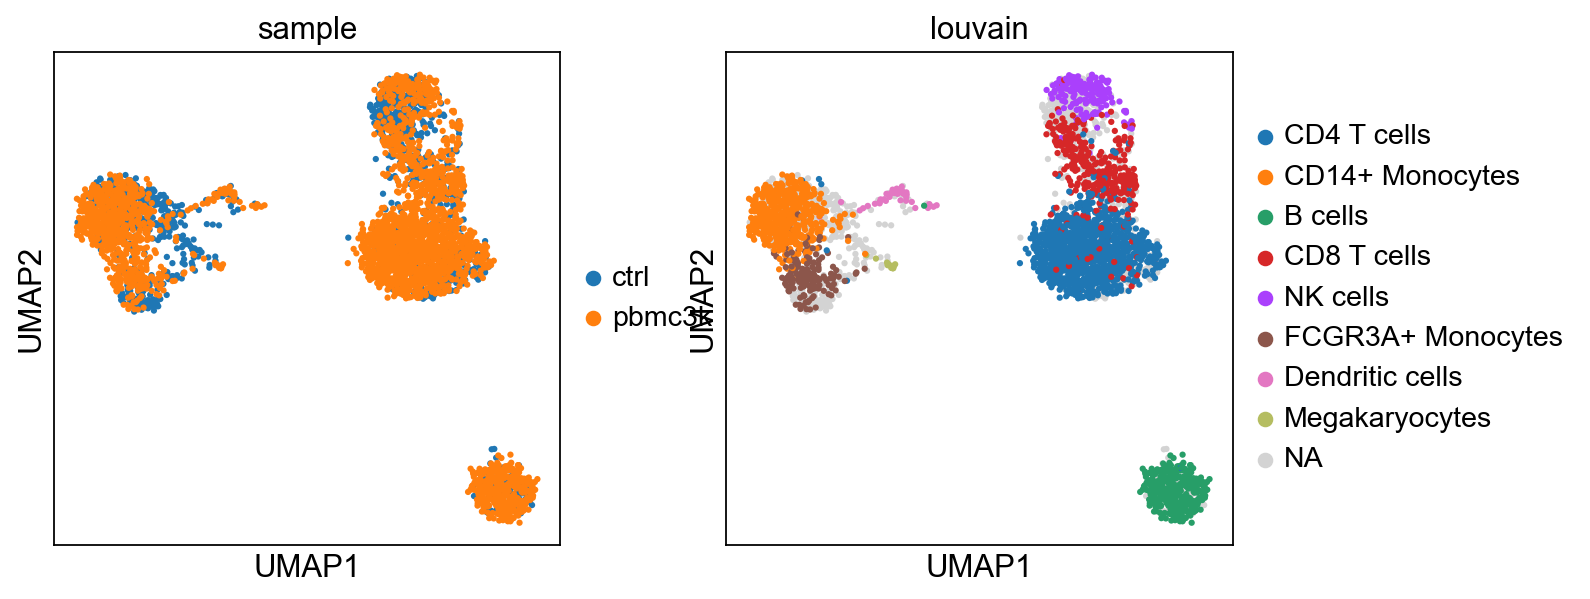

In [20]:
sc.pl.umap(adata_merged, color=["sample","louvain"])

 ### Label transfer

In [21]:
from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    adata_merged[adata_merged.obs['sample'] == "pbmc3k"].obsm["Scanorama"],
    adata_merged[adata_merged.obs['sample'] == "ctrl"].obsm["Scanorama"],
)

In [22]:
def label_transfer(dist, labels, index):
    lab = pd.get_dummies(labels)
    class_prob = lab.to_numpy().T @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    # convert to df
    cp_df = pd.DataFrame(
        class_prob, columns=lab.columns
    )
    cp_df.index = index
    # classify as max score
    m = cp_df.idxmax(axis=1)
    
    return m

In [23]:
class_def = label_transfer(distances, adata_ref.obs.louvain, adata.obs.index)

In [24]:
# add to obs section of the original object
adata.obs['predicted'] = class_def

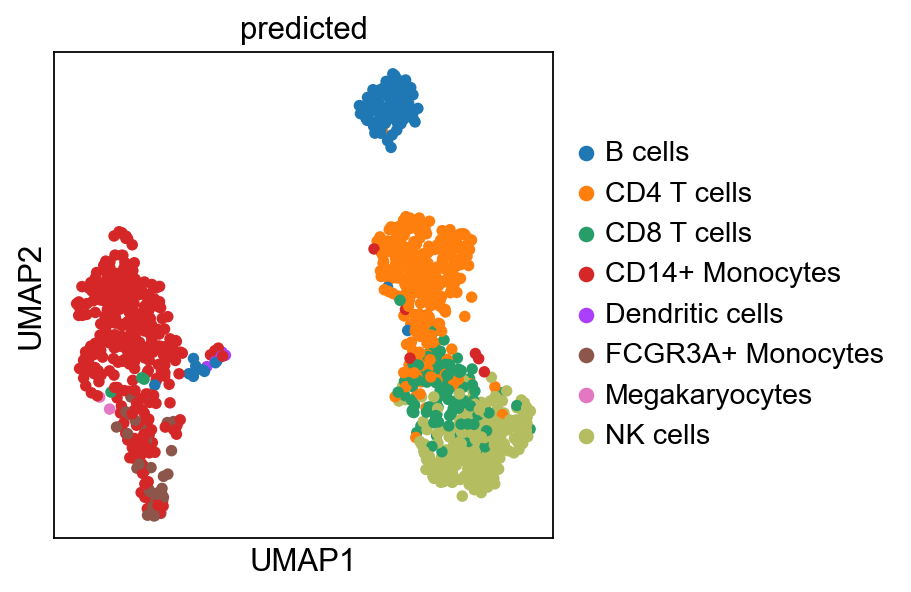

In [25]:
sc.pl.umap(adata, color="predicted")

In [ ]:
# add to merged object.
adata_merged.obs['predicted'] = class_def.append(adata_ref.obs['louvain']).tolist()

sc.pl.umap(adata_merged, color=["sample","louvain",'predicted'])
#plot only ctrl cells.
sc.pl.umap(adata_merged[adata_merged.obs['sample']=='ctrl'], color='predicted')